In [418]:
from numpy import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *

dat = loadtxt('../data/gvmin/gvmin_Halo.txt')
v_min = dat[0,:]
gmin_Halo = dat[1:,:]
gmin_Halo_gf = loadtxt('../data/gvmin/gvmin_Halo_GF.txt',skiprows=1)

gmin_Saus = loadtxt('../data/gvmin/gvmin_Saus.txt',skiprows=1)
gmin_Saus_gf = loadtxt('../data/gvmin/gvmin_Saus_GF.txt',skiprows=1)

#gmin_sub = loadtxt('../data/gvmin/gvmin_Shards.txt',skiprows=1)
#gmin_sub_gf = loadtxt('../data/gvmin/gvmin_Shards_GF.txt',skiprows=1)


gmin_S1 = loadtxt('../data/gvmin/gvmin_S1.txt',skiprows=1)
gmin_S1_gf = loadtxt('../data/gvmin/gvmin_S1_gf.txt',skiprows=1)

gmin_S2 = loadtxt('../data/gvmin/gvmin_S2.txt',skiprows=1)
gmin_S2_gf = loadtxt('../data/gvmin/gvmin_S2_gf.txt',skiprows=1)

gmin_Ret = loadtxt('../data/gvmin/gvmin_Ret.txt',skiprows=1)
gmin_Ret_gf = loadtxt('../data/gvmin/gvmin_Ret_gf.txt',skiprows=1)

gmin_Pro = loadtxt('../data/gvmin/gvmin_Pro.txt',skiprows=1)
gmin_Pro_gf = loadtxt('../data/gvmin/gvmin_Pro_gf.txt',skiprows=1)

gmin_LowE = loadtxt('../data/gvmin/gvmin_LowE.txt',skiprows=1)
gmin_LowE_gf = loadtxt('../data/gvmin/gvmin_LowE_gf.txt',skiprows=1)

gmin_sub = (gmin_S1+gmin_S2+gmin_Ret)+gmin_Pro+gmin_LowE
gmin_sub_gf = (gmin_S1_gf+gmin_S2_gf+gmin_Ret_gf)+gmin_Pro_gf+gmin_LowE_gf

eta = 0.2
gmin0 = (1-eta)*gmin_Halo + eta*gmin_Saus
gmin0_gf = (1-eta)*gmin_Halo_gf + eta*gmin_Saus_gf

ndays = shape(gmin0)[0]
days = linspace(0,365,ndays)


# Ionization energy range
n = 500
E_ee = logspace(log10(0.01),log10(50.0),n)

# DAMA Config.
MT = 2.46
Avals = array([23,127])
Zvals = array([11,53])
Qvals = array([0.1,0.09])
def DAMAEnergyRes(Q,E_nr):
    alph = 0.448
    beta = 9.1e-3
    return alph*sqrt(Q*E_nr)+beta*Q*E_nr

Emask1 = (E_ee>1.0)*(E_ee<3.0)
Emask2 = (E_ee>1.0)*(E_ee<6.0)

# DM params
fnp = 1.0
fRS = 1.0/(1.0*Avals**2.0)*((Avals-Zvals)*fnp + Zvals)**2.0
m_chi = 50.0
sigma_p = 1.0e-43



def MakeRateModulationBinned(gmin,gmin_gf):
    # diff rates
    dR = zeros(shape=(ndays,n))
    dR_gf = zeros(shape=(ndays,n))

    for nuc in range(0,2):
        C_N = fRS[nuc]
        A = Avals[nuc]
        Q = Qvals[nuc]
        E_nr = E_ee/Q
        v_min_E = MinimumWIMPSpeed(E_nr,A,m_chi)
        sig_E = DAMAEnergyRes(Q,E_nr)
        for i in range(0,ndays):
            g = interp(v_min_E,v_min,gmin[i,:])
            g_gf = interp(v_min_E,v_min,gmin_gf[i,:])
            dR[i,:] += C_N*SmearE(E_nr,diffRecoilRate_SI(E_nr,g,A,sigma_p,m_chi,rho_0=0.55),sig_E)
            dR_gf[i,:] += C_N*SmearE(E_nr,diffRecoilRate_SI(E_nr,g_gf,A,sigma_p,m_chi,rho_0=0.55),sig_E)             

    # total rates
    R = zeros(shape=(ndays,2))
    R_gf = zeros(shape=(ndays,2))
            
    for i in range(0,ndays):
        R[i,0] = MT*trapz(dR[i,Emask1],E_ee[Emask1])
        R_gf[i,0] = MT*trapz(dR_gf[i,Emask1],E_ee[Emask1])

        R[i,1] = MT*trapz(dR[i,Emask2],E_ee[Emask2])
        R_gf[i,1] = MT*trapz(dR_gf[i,Emask2],E_ee[Emask2])
    
    return dR,dR_gf,R,R_gf

dR0,dR0_gf,R0,R0_gf = MakeRateModulationBinned(gmin0,gmin0_gf)
dR,dR_gf,R,R_gf = MakeRateModulationBinned(gmin_sub,gmin_sub_gf)

dR_S1,dR_gf_S1,R_S1,R_gf_S1 = MakeRateModulationBinned(gmin_S1,gmin_S1_gf)
dR_S2,dR_gf_S2,R_S2,R_gf_S2 = MakeRateModulationBinned(gmin_S2,gmin_S2_gf)
dR_Ret,dR_gf_Ret,R_Ret,R_gf_Ret = MakeRateModulationBinned(gmin_Ret,gmin_Ret_gf)
dR_Pro,dR_gf_Pro,R_Pro,R_gf_Pro = MakeRateModulationBinned(gmin_Pro,gmin_Pro_gf)
dR_LowE,dR_gf_LowE,R_LowE,R_gf_LowE = MakeRateModulationBinned(gmin_LowE,gmin_LowE_gf)

Rsubs = dstack((R_S1,R_S2,R_Ret,R_Pro,R_LowE))
Rsubs_gf = dstack((R_gf_S1,R_gf_S2,R_gf_Ret,R_gf_Pro,R_gf_LowE))

dRsubs = dstack((dR_S1,dR_S2,dR_Ret,dR_Pro,dR_LowE))
dRsubs_gf = dstack((dR_gf_S1,dR_gf_S2,dR_gf_Ret,dR_gf_Pro,dR_gf_LowE))

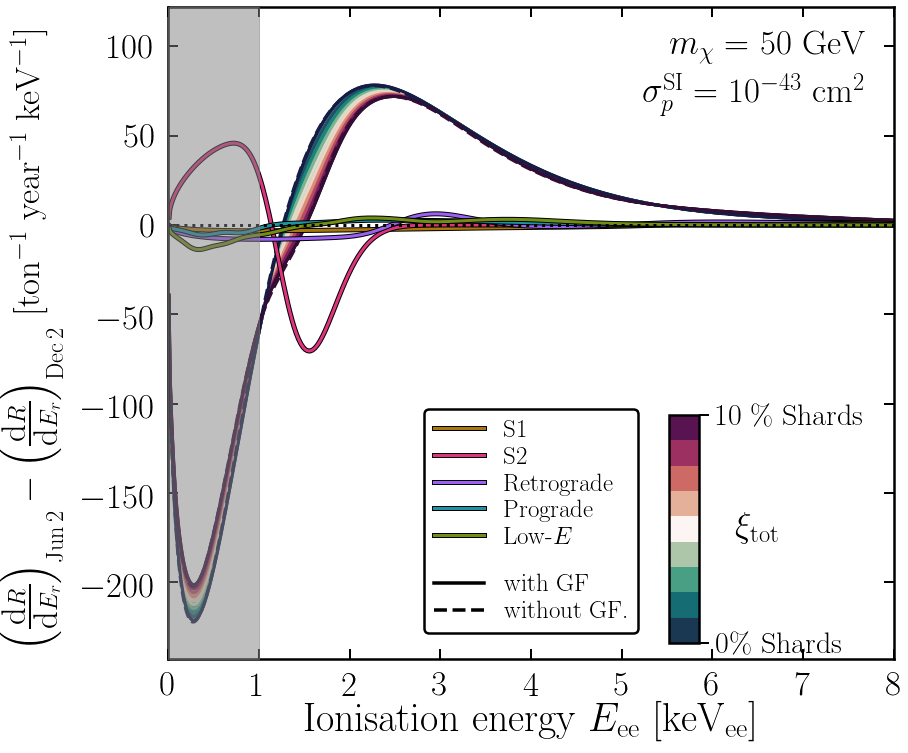

In [419]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean
import matplotlib.patheffects as pe


# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def ModulationAmplitude(dRv):
    Jun2 = argmin(abs(days-152.0))
    Dec2 = argmin(abs(days-336.0))
    ni = shape(dRv)[1]
    Rdiffv = zeros(shape=ni)
    for i in range(0,n):
        #Rdiffv[i] = max(dRv[:,i])-min(dRv[:,i])
        Rdiffv[i] = dRv[Jun2,i]-dRv[Dec2,i]
    return Rdiffv


# Figure
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(111)
#left, bottom, width, height = [0.53, 0.55, 0.35, 0.25]
#ax2 = fig.add_axes([left, bottom, width, height])
#left, bottom, width, height = [0.53, 0.3, 0.35, 0.25]
#ax3 = fig.add_axes([left, bottom, width, height])

n_xi = 10
xi_max = 0.1
xi_vals = linspace(0,xi_max,n_xi)
col = (cmocean.cm.curl(linspace(0,1,n_xi)))
cmap = cmocean.cm.curl

# Main plot
plt.sca(ax1)
y2_gf = ModulationAmplitude(xi_max*dR_gf+(1-xi_max)*dR0_gf)
for i in range(0,n_xi):
    y_gf = ModulationAmplitude(xi_vals[i]*dR_gf+(1-xi_vals[i])*dR0_gf)
    plt.fill_between(E_ee,y_gf,y2=y2_gf,color=col[i,:],alpha=0.5)
    plt.plot(E_ee,y_gf,'-',color=col[i,:],linewidth=3)
    
plt.plot(E_ee,ModulationAmplitude(dR0_gf),linewidth=3,color=col[0,:])
plt.plot(E_ee,y2_gf,linewidth=3,color=col[-1,:])


y2 = ModulationAmplitude(xi_max*dR+(1-xi_max)*dR0)
for i in range(0,n_xi):
    y = ModulationAmplitude(xi_vals[i]*dR+(1-xi_vals[i])*dR0)
    plt.fill_between(E_ee,y,y2=y2,color=col[i,:],alpha=0.0)
plt.plot(E_ee,ModulationAmplitude(dR0),'--',linewidth=3,color=col[0,:])
plt.plot(E_ee,y2,'--',linewidth=3,color=col[-1,:])


labs = ['S1','S2','Retrograde','Prograde','Low-$E$']
cols = (cmocean.cm.phase(linspace(0,0.9,5)))
zo=10
for isub in range(0,5):
    ysub = ModulationAmplitude(dRsubs[:,:,isub])
    ysub_gf = ModulationAmplitude(dRsubs_gf[:,:,isub])
    #plt.plot(E_ee,0.2*ysub_gf,'k-',lw=6)
    #plt.plot(E_ee,0.2*ysub_gf,'-',lw=4,color=cols[isub,:],label=labs[isub],zorder=zo)
    plt.plot(E_ee, 0.2*ysub_gf, color=cols[isub,:], lw=3, path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()],label=labs[isub])

    #plt.plot(E_ee,ysub,'--',lw=3,color=cols[isub,:])
    zo = zo-1

plt.plot(10.0,0.0,'w.',label='\quad')    

if m_chi<15.0:
    ymax = 50.0
    ymin = -50
    xmin = 0.2
else:
    ymax = amax(y2)*1.7
    ymin = amin(y2)*1.2
    xmin = 0.0

#ymin = 0.0
#ymax = 60.0
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"Ionisation energy $E_{\rm ee}$ [keV$_{\rm ee}$]",fontsize=40);
plt.ylabel(r"$\left(\frac{\textrm{d}R}{\textrm{d}E_r}\right)_{\rm Jun\,2} - \left(\frac{\textrm{d}R}{\textrm{d}E_r}\right)_{\rm Dec\,2}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]" ,fontsize=35,labelpad=10);
plt.fill_between([0,1],[ymax,ymax],y2=ymin,alpha=0.5,color='gray',edgecolor='none',zorder=5)
ax1.plot([0,100],[0,0],'k:',lw=3)
ax1.set_xlim(left=xmin,right=8.0)
ax1.set_ylim(bottom=ymin,top=ymax)
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=12)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax1.plot([-1.2,-2.0],[1.3,1.3], 'k-',linewidth=3.5,label='with GF')
ax1.plot([-1.2,-2.0],[1.18,1.18], 'k--',linewidth=3.5,label='without GF.')
leg = ax1.legend(loc='lower center',labelspacing=0.15,fontsize=25,framealpha=1,edgecolor='k',bbox_to_anchor=[0.5,0.02])
leg.get_frame().set_linewidth(2.5)


# Custom colorbar
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax1, width="15%", height="30%", bbox_to_anchor=[460, -395, 200, 760]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.73,0.26,r'$\xi_{\rm tot}$',fontsize=35,color='k')

plt.gcf().text(0.87,0.82,r'$m_\chi = $ '+str(int(m_chi))+' GeV',fontsize=35,horizontalalignment='right')
plt.gcf().text(0.87,0.76,r'$\sigma^{\rm SI}_p = 10^{'+str(int(log10(sigma_p)))+'}$ cm$^2$',fontsize=35,horizontalalignment='right')

plt.show()
pltname = 'Shards_annualmod_gravfocus_'+str(int(m_chi))+'GeV'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

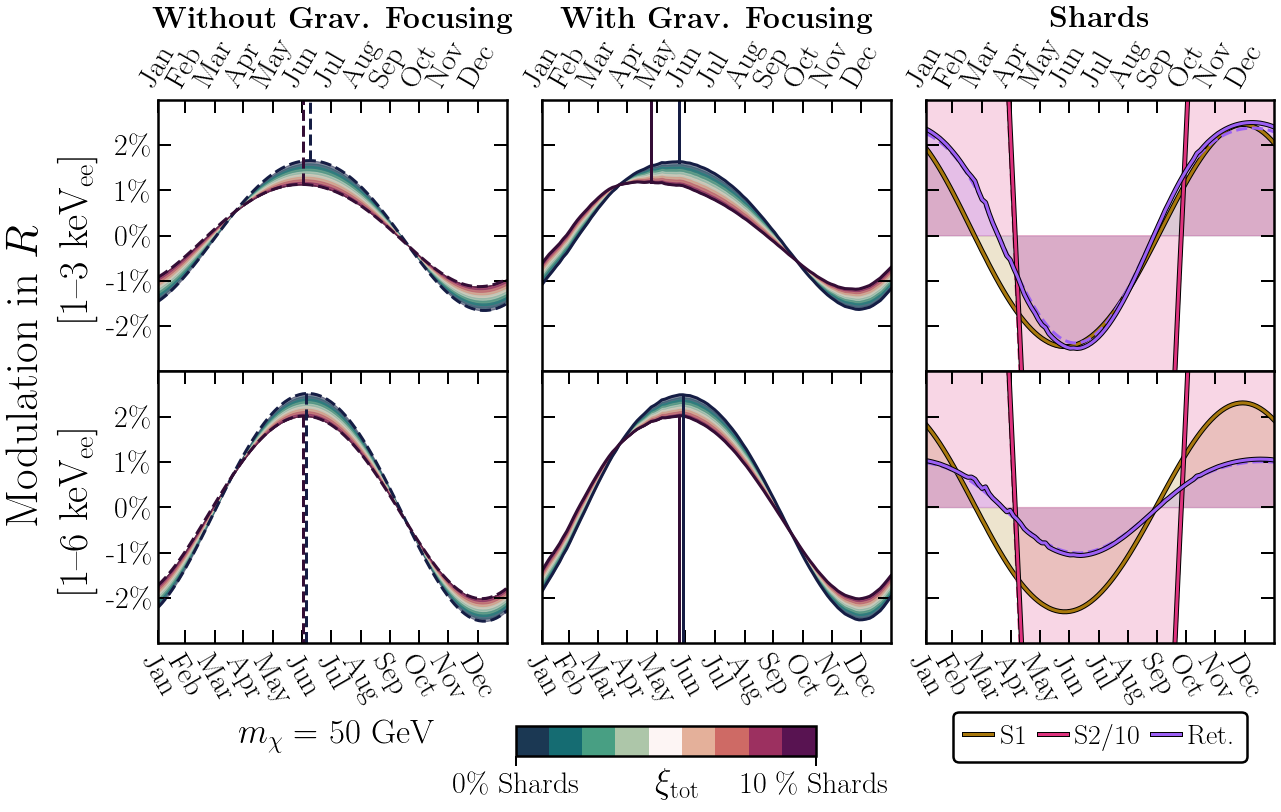

In [420]:
lfs = 30

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthsi = cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31

fig, axarr = plt.subplots(2, 3,figsize=(20,10))
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.1,hspace=0.0)
ax11 = plt.subplot(gs[0,0])
ax12 = plt.subplot(gs[1,0])
ax21 = plt.subplot(gs[0,1])
ax22 = plt.subplot(gs[1,1])
ax31 = plt.subplot(gs[0,2])
ax32 = plt.subplot(gs[1,2])


ymin = -3.0
ymax = 3.0
ytx = [-2,-1,0,1,2]
ytx_labs= ['-2\%','-1\%','0\%','1\%','2\%']
xmin = 0.0
xmax = 365.0

ax11.set_ylabel(r"[1--3 keV$_{\rm ee}$]" ,fontsize=lfs+10)
ax12.set_ylabel(r"[1--6 keV$_{\rm ee}$]" ,fontsize=lfs+10)
plt.gcf().text(0.02,0.3,r"Modulation in $R$" ,fontsize=lfs+15,rotation=90);

ax11.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax11.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax12.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax12.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)

ax21.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax21.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax22.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax22.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)

ax31.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax31.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
ax32.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
ax32.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)


ax11.xaxis.tick_top()
ax21.xaxis.tick_top()
ax31.xaxis.tick_top()

ax11.set_ylim([ymin,ymax])
ax12.set_ylim([ymin,ymax])
ax21.set_ylim([ymin,ymax])
ax22.set_ylim([ymin,ymax])
ax31.set_ylim([ymin,ymax])
ax32.set_ylim([ymin,ymax])

ax11.set_xlim([xmin,xmax])
ax12.set_xlim([xmin,xmax])
ax21.set_xlim([xmin,xmax])
ax22.set_xlim([xmin,xmax])
ax31.set_xlim([xmin,xmax])
ax32.set_xlim([xmin,xmax])

ax21.set_yticklabels([])
ax22.set_yticklabels([])
ax31.set_yticklabels([])
ax32.set_yticklabels([])

ax11.set_yticks(ytx)
ax12.set_yticks(ytx)

ax21.set_yticks(ytx)
ax22.set_yticks(ytx)

ax31.set_yticks(ytx)
ax32.set_yticks(ytx)

ax11.set_yticklabels(ytx_labs,fontsize=lfs)
ax12.set_yticklabels(ytx_labs,fontsize=lfs)


ax12.set_xticks(monthsi)
ax12.set_xticklabels(months,rotation=-60,fontsize=lfs)
ax11.set_xticks(monthsi)
ax11.set_xticklabels(months,rotation=60,fontsize=lfs)

ax22.set_xticks(monthsi)
ax22.set_xticklabels(months,rotation=-60,fontsize=lfs)
ax21.set_xticks(monthsi)
ax21.set_xticklabels(months,rotation=60,fontsize=lfs)

ax32.set_xticks(monthsi)
ax32.set_xticklabels(months,rotation=-60,fontsize=lfs)
ax31.set_xticks(monthsi)
ax31.set_xticklabels(months,rotation=60,fontsize=lfs)


#ax2.set_yticks(arange(-5,7,2))
#ax3.set_yticks(arange(-6,6,2))

# # Inset plot 1
# plt.sca(ax11)
# ymax = 3.0


def ModPerc(R):
    Rmid = (amax(R)+amin(R))/2.0
    Rt = 100*(R-Rmid)/Rmid
    return Rt


plt.sca(ax11)
plt.title(r'{\bf Without Grav. Focusing}',fontsize=30)
for ibin in [0,1]:
    y0 = ModPerc(xi_vals[0]*R[:,ibin]+(1-xi_vals[0])*R0[:,ibin])
    y2 = ModPerc(xi_vals[-1]*R[:,ibin]+(1-xi_vals[-1])*R0[:,ibin])
    for i in range(0,n_xi):
        Rt = ModPerc(xi_vals[i]*R[:,ibin]+(1-xi_vals[i])*R0[:,ibin])
        plt.fill_between(days,Rt,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(days,y0,'--',linewidth=3,color=col[0,:])
    plt.plot(days,y2,'--',linewidth=3,color=col[-1,:])

    if ibin==0:
        yend = ymax
    else:
        yend = ymin

    # vertical lines
    plt.plot([days[argmax(y0)],days[argmax(y0)]],[amax(y0),yend],'--',color=col[0,:],lw=3)
    plt.plot([days[argmax(y2)],days[argmax(y2)]],[amax(y2),yend],'--',color=col[-1,:],lw=3)
    plt.sca(ax12)

    
plt.sca(ax21)
plt.title(r'{\bf With Grav. Focusing}',fontsize=30)
for ibin in [0,1]:
    y0 = ModPerc(xi_vals[0]*R_gf[:,ibin]+(1-xi_vals[0])*R0_gf[:,ibin])
    y2 = ModPerc(xi_vals[-1]*R_gf[:,ibin]+(1-xi_vals[-1])*R0_gf[:,ibin])
    for i in range(0,n_xi):
        Rt = ModPerc(xi_vals[i]*R_gf[:,ibin]+(1-xi_vals[i])*R0_gf[:,ibin])
        plt.fill_between(days,Rt,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(days,y0,'-',linewidth=3,color=col[0,:])
    plt.plot(days,y2,'-',linewidth=3,color=col[-1,:])

    if ibin==0:
        yend = ymax
    else:
        yend = ymin

    # vertical lines
    plt.plot([days[argmax(y0)],days[argmax(y0)]],[amax(y0),yend],'-',color=col[0,:],lw=3)
    plt.plot([days[argmax(y2)],days[argmax(y2)]],[amax(y2),yend],'-',color=col[-1,:],lw=3)
    plt.sca(ax22)
    
    
ws = [1,1,1,1,1]
labs = [r'S1',r'S2/10',r'Ret.',r'Pro.',r'Low-$E$']
for isub in range(0,3):
    plt.sca(ax31)
    for ibin in [0,1]:
        y2 = ModPerc(Rsubs[:,ibin,isub])
        y2_gf = ModPerc(Rsubs_gf[:,ibin,isub])
        plt.fill_between(days,ws[isub]*y2_gf,y2=0.0,color=cols[isub,:],alpha=0.2)
        plt.plot(days,ws[isub]*y2,'--',linewidth=3,color=cols[isub,:])
        plt.plot(days,ws[isub]*y2_gf, color=cols[isub,:], lw=3, path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()],label=labs[isub])
        plt.sca(ax32)

leg = plt.legend(loc='upper center',\
                 bbox_to_anchor=[0.5,-0.2],fontsize=28,\
                 edgecolor='k',ncol=3,handletextpad=0.3,\
                 facecolor='w',framealpha=1,\
                 labelspacing=0.1,columnspacing=0.4,\
                handlelength=1.0)
leg.get_frame().set_linewidth(2.5)


ax31.set_title(r'{\bf Shards}',fontsize=30)



# # Inset plot 2
# plt.sca(ax3)

# R = sum(R_NaI[:,:,1],1)
# R_gf = sum(R_gf_NaI[:,:,1],1)
# R0 = sum(R0_NaI[:,:,1],1)
# R0_gf = sum(R0_gf_NaI[:,:,1],1)

# R0mid = (max(R0)+min(R0))/2.0
# Rmid = (max(R)+min(R))/2.0
# R0mid_gf = (max(R0_gf)+min(R0_gf))/2.0
# Rmid_gf = (max(R_gf)+min(R_gf))/2.0
# y2 = 100*xi_vals[-1]*(R-Rmid)/Rmid+100*(1.0-xi_vals[-1])*(R0-R0mid)/R0mid
# y2_gf = 100*xi_vals[-1]*(R_gf-Rmid_gf)/Rmid_gf+100*(1.0-xi_vals[-1])*(R0_gf-R0mid_gf)/R0mid_gf

# for i in range(0,n_xi):
#     Rt = 100*xi_vals[i]*(R-Rmid)/Rmid+100*(1.0-xi_vals[i])*(R0-R0mid)/R0mid
#     plt.fill_between(days,Rt,y2=y2,color=col[i,:],alpha=0.5)
#     plt.plot(days,Rt,'-',color=col[i,:],linewidth=3)
# plt.plot(days,100*(R0-R0mid)/R0mid,linewidth=3,color=col[0,:])
# plt.plot(days,y2,linewidth=3,color=col[-1,:])
# plt.plot(days,100*(R0_gf-R0mid_gf)/R0mid_gf,'--',linewidth=3,color=col[0,:])
# plt.plot(days,y2_gf,'--',linewidth=3,color=col[-1,:])

# # vertical lines
# diffR = 100*(R0-R0mid)/R0mid
# plt.plot([days[argmax(diffR)],days[argmax(diffR)]],[-ymax,amax(diffR)],'-',color=col[0,:])
# plt.plot([days[argmax(y2)],days[argmax(y2)]],[-ymax,amax(y2)],'-',color=col[-1,:])

# diffR_gf = 100*(R0_gf-R0mid_gf)/R0mid_gf
# plt.plot([days[argmax(diffR_gf)],days[argmax(diffR_gf)]],[-ymax,amax(diffR_gf)],'--',color=col[0,:])
# plt.plot([days[argmax(y2_gf)],days[argmax(y2_gf)]],[-ymax,amax(y2_gf)],'--',color=col[-1,:])



# plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
#            ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
#            rotation=60)

#plt.gcf().text(0.73,0.5,r'$1-6$ keV',fontsize=30,bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.2',lw=2))
#plt.gcf().text(0.73,0.75,r'$1-3$ keV',fontsize=30,bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.2',lw=2))


# Custom colorbar
cbar_max = r'10 \% Shards'
cbar_min = r'0\% Shards'
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax12, width="15%", height="30%", bbox_to_anchor=[-1150, -80, 2000, 100]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[7]
cbar.set_xticklabels([cbar_min,cbar_max]) 
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
plt.gcf().text(0.47,-0.09,r'$\xi_{\rm tot}$',fontsize=35,color='k')
plt.gcf().text(0.18,-0.02,r'$m_\chi = $ '+str(int(m_chi))+' GeV',fontsize=35)



plt.show()
pltname = 'Shards_annualmod_binned_'+str(int(m_chi))+'GeV'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

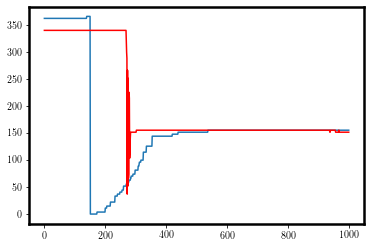

In [304]:

nv = size(v_min)

t0 = zeros(shape=nv)
for i in range(0,nv):
    t0[i] = days[argmax(gmin_Halo_gf[:,i])]
plt.plot(t0)

t1 = zeros(shape=nv)
for i in range(0,nv):
    t1[i] = days[argmax(gmin_Halo[:,i])]
plt.plot(t1,'r-')


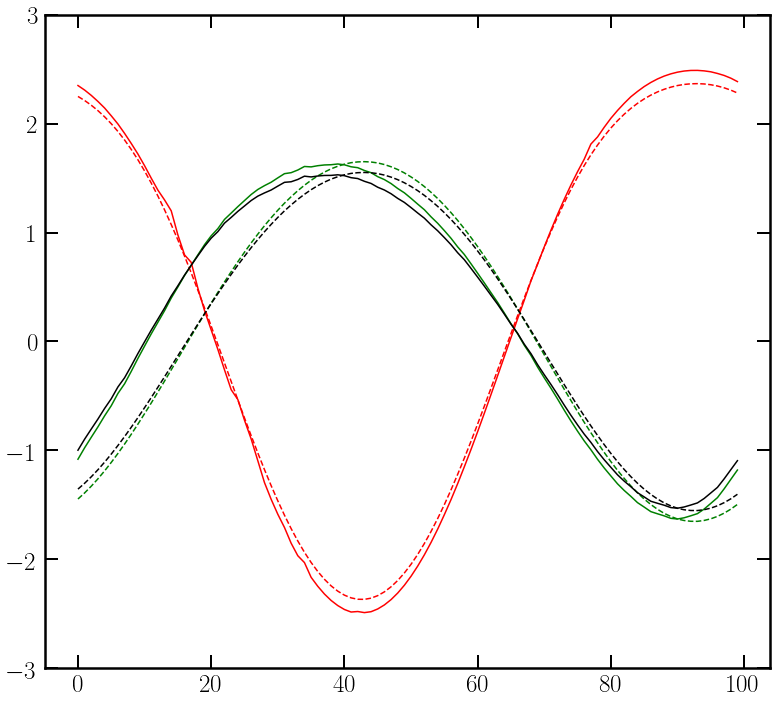

In [430]:
import PlotFuncs
fig,ax = PlotFuncs.MySquarePlot()
#for isub in range(0,3):
#    plt.plot(Rsubs[:,0,isub],'--',color=cols[isub,:])
#    plt.plot(Rsubs_gf[:,0,isub],'-',color=cols[isub,:])

#r0 = Rsubs[:,0,0]+Rsubs[:,0,1]+Rsubs[:,0,2]
#r1 = Rsubs_gf[:,0,0]+Rsubs_gf[:,0,1]+Rsubs_gf[:,0,2]
#plt.plot(r0,'k--')
#plt.plot(r1,'k-')


xi = 0.1


r = Rsubs[:,0,2]
#plt.plot(y,'r--')
plt.plot(ModPerc((1-xi)*R0[:,0]),'g--')
plt.plot(ModPerc((xi*r)),'r--')

r_gf = Rsubs_gf[:,0,2]
y = ((1-xi)*R0_gf[:,0]+xi*r_gf)
plt.plot(ModPerc((1-xi)*R0_gf[:,0]),'g-')
plt.plot(ModPerc(xi*r_gf),'r-')

plt.plot(ModPerc(xi*r_gf+(1-xi)*R0_gf[:,0]),'k-')
plt.plot(ModPerc(xi*r+(1-xi)*R0[:,0]),'k--')

plt.ylim([-3,3])
plt.show()

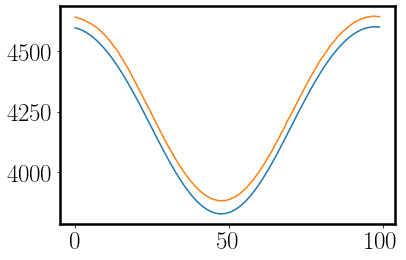

In [399]:
plt.plot(r)
plt.plot(r_gf)

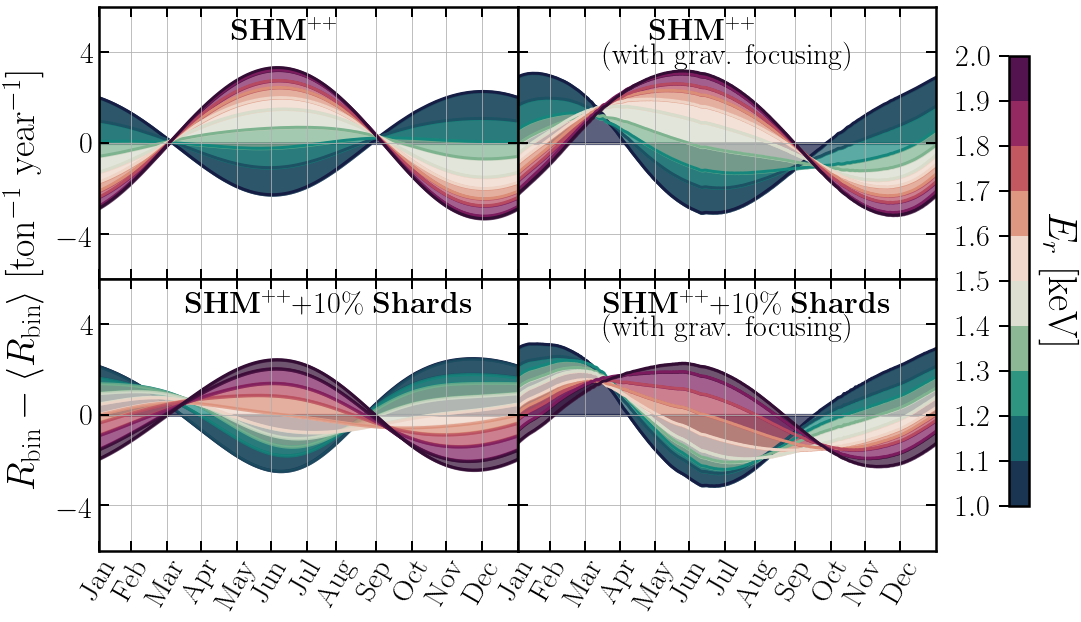

In [164]:
import matplotlib.gridspec as gridspec
import pandas as pd


nbins = 10
bin_edges = linspace(1.0,2.0,nbins+1)

def bin_dR(fdR):
    Rbin = zeros(shape=(ndays,nbins))
    for i in range(0,ndays):
        for j in range(0,nbins):
            E1 = bin_edges[j]
            E2 = bin_edges[j+1]
            Ec = E_ee[(E_ee>E1)&(E_ee<E2)]
            dRc = fdR[i,(E_ee>E1)&(E_ee<E2)]
            Rbin[i,j] = trapz(dRc,Ec)
    return Rbin

xi = 0.1

Rbin0 = bin_dR(dR0)
Rbin0_gf = bin_dR(dR0_gf)
Rbin = bin_dR((1-xi)*dR0+xi*dR)
Rbin_gf = bin_dR((1-xi)*dR0_gf+xi*dR_gf)

#for i in range(0,nbins):
#    Rbin0_gf[:,i] = pd.DataFrame(Rbin0_gf[:,i]).rolling(9).mean().values.T
#    Rbin_gf[:,i] = pd.DataFrame(Rbin_gf[:,i]).rolling(9).mean().values.T
#Rbin0_gf[isnan(Rbin0_gf)] = Rbin0_gf[0,5]
#Rbin_gf[isnan(Rbin_gf)] = Rbin_gf[0,5]
   
# Set up subplots
fig, axarr = plt.subplots(2, 2,figsize=(15,10))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.0,wspace=0.0)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

ymax = 6.0
labelx = 115
labely = 0.75*ymax
ticklocs = cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31
ticklocs[7] -= 5
ticklabs = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ytx = [-4,0.0,4]
plt.sca(ax1)
import cmocean
colbins = (cmocean.cm.curl(linspace(0,1,nbins)))
cmap = cmocean.cm.curl
y2 = 0.0
zo = -10.0
for i in range(0,nbins):
    yc = Rbin0[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7,zorder=zo)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:],zorder=zo)
plt.xticks(ticklocs)
plt.text(labelx,labely,r'{\bf SHM}$^{++}$',fontsize=30)
plt.yticks(ytx)

    
plt.sca(ax2)
y2 = 0.0
zo = -10.0
for i in range(0,nbins):
    yc = Rbin0_gf[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7,zorder=zo)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:],zorder=zo)
plt.xticks(ticklocs)
plt.text(labelx,labely,r'{\bf SHM}$^{++}$',fontsize=30)
plt.text(labelx-40,labely-1,r'(with grav. focusing)',fontsize=30)
plt.yticks(ytx)

plt.sca(ax3)
y2 = 0.0
zo = -10.0
for i in range(0,nbins):
    yc = Rbin[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7,zorder=zo)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:],zorder=zo)
    zo += 1
plt.xticks(ticklocs,ticklabs,rotation=60)
plt.text(labelx-40,labely,r'{\bf SHM}$^{++}$+10\% {\bf Shards}',fontsize=30)
plt.yticks(ytx)


plt.sca(ax4)
y2 = 0.0
zo = -10.0
for i in range(0,nbins):
    yc = Rbin_gf[:,i]
    Rmid = (max(yc)+min(yc))/2.0
    plt.fill_between(days,yc-Rmid,y2=y2,linewidth=3,color=colbins[i,:],alpha=0.7,zorder=zo)
    y2 = yc-Rmid
    plt.plot(days,yc-Rmid,'-',linewidth=3,color=colbins[i,:],zorder=zo)   
plt.xticks(ticklocs,ticklabs,rotation=60)
plt.text(labelx-40,labely,r'{\bf SHM}$^{++}$+10\% {\bf Shards}',fontsize=30)
plt.text(labelx-40,labely-1,r'(with grav. focusing)',fontsize=30)
plt.yticks(ytx)

    
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax4.set_yticklabels([])


ax1.set_xlim([0,days[-1]])
ax2.set_xlim([0,days[-1]])
ax3.set_xlim([0,days[-1]])
ax4.set_xlim([0,days[-1]])
ax1.set_ylim([-ymax,ymax])
ax2.set_ylim([-ymax,ymax])
ax3.set_ylim([-ymax,ymax])
ax4.set_ylim([-ymax,ymax])

# Custom colorbar
cbaxes = inset_axes(ax2, width="10%", height="90%", bbox_to_anchor=[870, 90, 200, 500]) 
norm = mpl.colors.Normalize(vmin=bin_edges[0],vmax=bin_edges[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=around(bin_edges,2),boundaries=around(bin_edges,2),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[5]
cbar.tick_params(labelsize=20) 
cbar.tick_params(which='major',direction='out',width=2,length=10,left=True,right=False,pad=7,labelsize=30)
cbar.tick_params(which='minor',direction='out',width=2,length=7,left=True,right=False)
cbar.yaxis.set_ticks_position('left')
cbar.set_ylabel(r'$E_{\rm ee}$ [keV$_{\rm ee}$]',rotation=-90,labelpad=45)
cbar.yaxis.label.set_size(40)
#cbar.yaxis.set_label_position("right")
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax2.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax3.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax3.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
ax4.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=30)
ax4.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)

#ax1.set_ylabel(r'\quad\quad\quad$R_{\rm bin}-\langle R_{\rm bin}\rangle$ [ton$^{-1}$ year$^{-1}$]',fontsize=30)
#ax3.set_ylabel(r'\quad\quad\quad$R_{\rm bin}-\langle R_{\rm bin}\rangle$ [ton$^{-1}$ year$^{-1}$]',fontsize=30)
plt.gcf().text(0.04,0.22,r'\quad\quad\quad$R_{\rm bin}-\langle R_{\rm bin}\rangle$ [ton$^{-1}$ year$^{-1}$]',rotation=90,fontsize=38)

plt.show()
pltname = 'Shards_annualmod_gravfocus_Energies'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

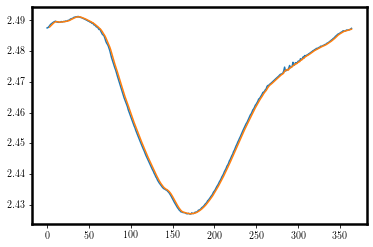

In [20]:
import pandas as pd

plt.plot(Rbin_gf[:,0])

df_R = pd.DataFrame(Rbin_gf[:,0])
smooth_data = df_R.rolling(4).mean()
plt.plot(smooth_data)

plt.show()

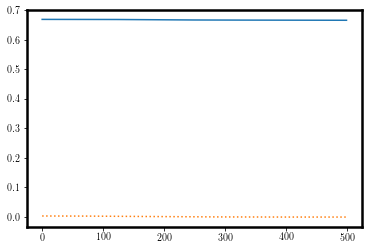

In [17]:
plt.plot(gmin_sub[1,:])
plt.plot(gmin_Halo[1,:],':')

plt.show()

In [26]:
df0 = pd.DataFrame(Rbin0_gf[:,i]).rolling(9).mean().values
df1 = pd.DataFrame(Rbin_gf[:,i]).rolling(9).mean()

In [321]:
v_lab = LabVelocitySimple(67)
nyx = array([156,141,-1.4])
S2 = array([6.1,166.8,-242.7])
print(sqrt(sum((v_lab-nyx)**2.0)))
print(sqrt(sum((v_lab-S2)**2.0)))

156.15326353446818
269.814047449343


In [325]:
print((1e6)*(sum((v_lab-S2)**2.0))/(2*(3.0e8/1000)**2.0))
print((1e6)*(sum((v_lab-nyx)**2.0))/(2*(3.0e8/1000)**2.0))

0.40444233444997957
0.13546578729147263


In [340]:
gmin_Saus

array([[3.59350029e-03, 3.59344546e-03, 3.59339063e-03, ...,
        9.82232000e-08, 8.67056000e-08, 7.72952000e-08],
       [3.58943431e-03, 3.58937973e-03, 3.58932516e-03, ...,
        1.04661600e-07, 9.27360000e-08, 8.30208000e-08],
       [3.58494318e-03, 3.58488888e-03, 3.58483458e-03, ...,
        1.13932800e-07, 1.01581600e-07, 9.13920000e-08],
       ...,
       [3.60289605e-03, 3.60284064e-03, 3.60278522e-03, ...,
        8.28200000e-08, 7.22888000e-08, 6.38912000e-08],
       [3.60024362e-03, 3.60018837e-03, 3.60013312e-03, ...,
        8.72248000e-08, 7.64512000e-08, 6.78048000e-08],
       [3.59711305e-03, 3.59705799e-03, 3.59700294e-03, ...,
        9.12400000e-08, 8.02232000e-08, 7.12808000e-08]])

In [341]:
gmin0_gf

array([[3.62874245e-03, 3.62869332e-03, 3.62864420e-03, ...,
        1.15736000e-07, 1.03127200e-07, 9.28080000e-08],
       [3.62774044e-03, 3.62769131e-03, 3.62764219e-03, ...,
        1.24873600e-07, 1.11823200e-07, 1.00996000e-07],
       [3.62605991e-03, 3.62601078e-03, 3.62596165e-03, ...,
        1.34982400e-07, 1.21423200e-07, 1.10072000e-07],
       ...,
       [3.62897755e-03, 3.62892842e-03, 3.62887929e-03, ...,
        9.82968000e-08, 8.67944000e-08, 7.74720000e-08],
       [3.62933430e-03, 3.62928517e-03, 3.62923604e-03, ...,
        1.02731200e-07, 9.09576000e-08, 8.13240000e-08],
       [3.62919300e-03, 3.62914387e-03, 3.62909475e-03, ...,
        1.09041600e-07, 9.68272000e-08, 8.68864000e-08]])